In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from keras.datasets import mnist
import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from plotnine import *
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation
import os

**Reading in Data**

In [3]:
artists_data = pd.read_csv(r"C:\Users\Sara\Desktop\CPSC 393\Final Project\best-artworks-of-all-time\artists.csv")


In [4]:
%pip install opendatasets

You should consider upgrading via the 'c:\Users\Sara\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
import opendatasets as od
import pandas

data_url = "https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time"
od.download(data_url)

Skipping, found downloaded files in ".\best-artworks-of-all-time" (use force=True to force download)


In [6]:
import matplotlib.pyplot as plt
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("images")
new_base_dir = pathlib.Path("best-artworks-of-all-time")

In [7]:
photo_dir = 'images'

In [8]:
artwork_dataset = image_dataset_from_directory(
    new_base_dir / "images",
    image_size=(224, 224),
    batch_size=32)

Found 8774 files belonging to 51 classes.


In [9]:
class_name = artwork_dataset.class_names
print(class_name)

['Albrecht_DuΓòá├¬rer', 'Albrecht_Du╠êrer', 'Alfred_Sisley', 'Amedeo_Modigliani', 'Andrei_Rublev', 'Andy_Warhol', 'Camille_Pissarro', 'Caravaggio', 'Claude_Monet', 'Diego_Rivera', 'Diego_Velazquez', 'Edgar_Degas', 'Edouard_Manet', 'Edvard_Munch', 'El_Greco', 'Eugene_Delacroix', 'Francisco_Goya', 'Frida_Kahlo', 'Georges_Seurat', 'Giotto_di_Bondone', 'Gustav_Klimt', 'Gustave_Courbet', 'Henri_Matisse', 'Henri_Rousseau', 'Henri_de_Toulouse-Lautrec', 'Hieronymus_Bosch', 'Jackson_Pollock', 'Jan_van_Eyck', 'Joan_Miro', 'Kazimir_Malevich', 'Leonardo_da_Vinci', 'Marc_Chagall', 'Michelangelo', 'Mikhail_Vrubel', 'Pablo_Picasso', 'Paul_Cezanne', 'Paul_Gauguin', 'Paul_Klee', 'Peter_Paul_Rubens', 'Pierre-Auguste_Renoir', 'Piet_Mondrian', 'Pieter_Bruegel', 'Raphael', 'Rembrandt', 'Rene_Magritte', 'Salvador_Dali', 'Sandro_Botticelli', 'Titian', 'Vasiliy_Kandinskiy', 'Vincent_van_Gogh', 'William_Turner']


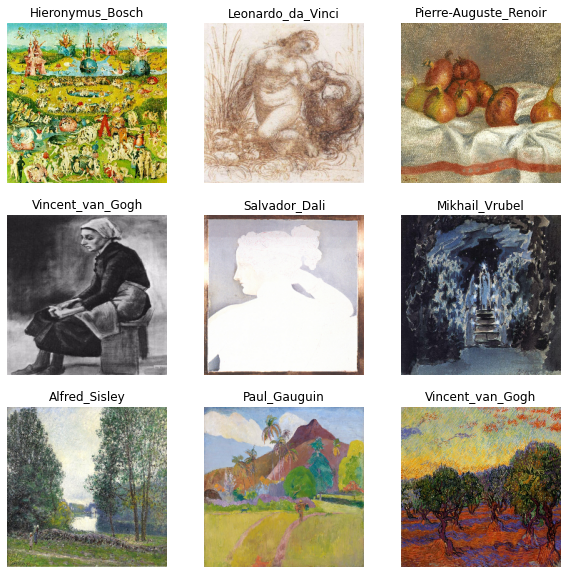

In [10]:
plt.figure(figsize=(10, 10))

for images, labels in artwork_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis('off')

**Some Data Analysis On The Artists Dataset**

In [11]:
artists_data.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [12]:
# dropping unneseccary columns/variables
artists_data.drop(["id","bio","wikipedia"],axis=1,inplace=True)

In [13]:
# to see the percent of how many null values in the data
((artists_data.isnull() | artists_data.isna()).sum() * 100 / artists_data.index.size).round(2)

name           0.0
years          0.0
genre          0.0
nationality    0.0
paintings      0.0
dtype: float64

In [14]:
artists_data["genre"].unique()

array(['Expressionism', 'Expressionism,Abstractionism',
       'Social Realism,Muralism', 'Impressionism',
       'Surrealism,Impressionism', 'Surrealism', 'Realism,Impressionism',
       'Byzantine Art', 'Post-Impressionism', 'Symbolism,Art Nouveau',
       'Northern Renaissance', 'Suprematism', 'Symbolism', 'Cubism',
       'Baroque', 'Romanticism', 'Primitivism,Surrealism', 'Mannerism',
       'Primitivism', 'Proto Renaissance', 'Early Renaissance',
       'High Renaissance', 'Impressionism,Post-Impressionism',
       'High Renaissance,Mannerism', 'Realism', 'Symbolism,Expressionism',
       'Expressionism,Abstractionism,Surrealism', 'Neoplasticism',
       'Pop Art', 'Symbolism,Post-Impressionism',
       'Abstract Expressionism'], dtype=object)

In [15]:
artists_data["nationality"].unique()

array(['Italian', 'Russian', 'Mexican', 'French', 'Belgian', 'Spanish',
       'Dutch', 'Austrian', 'Flemish', 'Spanish,Greek', 'German',
       'French,British', 'French,Jewish,Belarusian', 'British',
       'Norwegian', 'German,Swiss', 'American'], dtype=object)

In [16]:
genre_grouped = artists_data.groupby('genre').size()
genre_grouped

genre
Abstract Expressionism                     1
Baroque                                    4
Byzantine Art                              1
Cubism                                     1
Early Renaissance                          1
Expressionism                              1
Expressionism,Abstractionism               1
Expressionism,Abstractionism,Surrealism    1
High Renaissance                           3
High Renaissance,Mannerism                 1
Impressionism                              4
Impressionism,Post-Impressionism           2
Mannerism                                  1
Neoplasticism                              1
Northern Renaissance                       4
Pop Art                                    1
Post-Impressionism                         4
Primitivism                                2
Primitivism,Surrealism                     1
Proto Renaissance                          1
Realism                                    1
Realism,Impressionism                      1
Roma

In [17]:
nationality_grouped = artists_data.groupby('nationality').size()
nationality_grouped

nationality
American                     2
Austrian                     1
Belgian                      1
British                      1
Dutch                        4
Flemish                      3
French                      13
French,British               1
French,Jewish,Belarusian     1
German                       1
German,Swiss                 1
Italian                      8
Mexican                      2
Norwegian                    1
Russian                      4
Spanish                      5
Spanish,Greek                1
dtype: int64

In [18]:
#sorting the artists by the number of paintings created in aescending order
artist_paintings = artists_data[["name", "paintings"]]
artist_paintings.sort_values(by=["paintings"])

,name,paintings
49,Jackson Pollock,24
39,Eugene Delacroix,31
41,Georges Seurat,43
38,Paul Cezanne,47
48,Michelangelo,49
25,Caravaggio,55
34,Gustave Courbet,59
36,William Turner,66
37,Edvard Munch,67
40,Henri Rousseau,70


In [19]:
# creating a new column called age based on the year column
df_year = pd.DataFrame(artists_data.years.str.split(' ',2).tolist(),columns = ['birth','-','death'])
df_year.drop(["-"],axis=1,inplace=True)
artists_data["birth"]=df_year.birth
artists_data["death"]=df_year.death
artists_data.drop(["years"],axis=1,inplace=True)

artists_data["birth"]=artists_data["birth"].apply(lambda x: int(x))
artists_data["death"]=artists_data["death"].apply(lambda x: int(x))
artists_data["age"]=artists_data.death-artists_data.birth

In [20]:
artists_data.head()

,name,genre,nationality,paintings,birth,death,age
0,Amedeo Modigliani,Expressionism,Italian,193,1884,1920,36
1,Vasiliy Kandinskiy,"Expressionism,Abstractionism",Russian,88,1866,1944,78
2,Diego Rivera,"Social Realism,Muralism",Mexican,70,1886,1957,71
3,Claude Monet,Impressionism,French,73,1840,1926,86
4,Rene Magritte,"Surrealism,Impressionism",Belgian,194,1898,1967,69


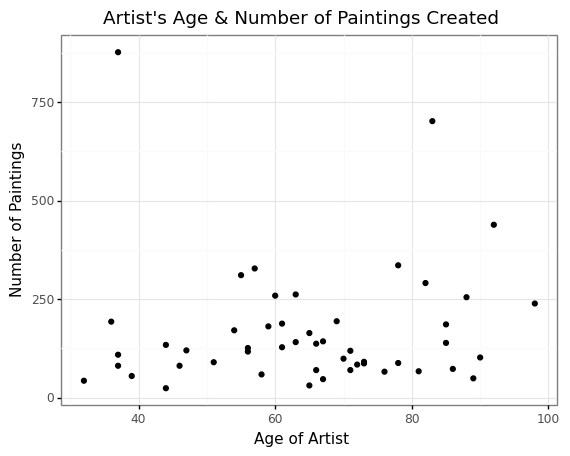

<ggplot: (88542828514)>

In [21]:
ggplot(artists_data) + aes(x = "age", y = "paintings") + geom_point() +theme_minimal() + theme_bw() + labs(x = "Age of Artist", y = "Number of Paintings") + ggtitle("Artist's Age & Number of Paintings Created")

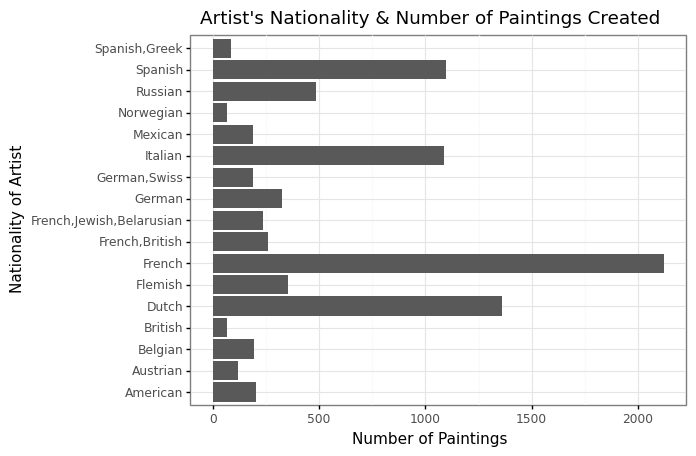

<ggplot: (88542894008)>

In [22]:
ggplot(artists_data) + aes(x = "nationality", y = "paintings") + geom_col() +theme_minimal() + theme_bw() + labs(x = "Nationality of Artist", y = "Number of Paintings") + ggtitle("Artist's Nationality & Number of Paintings Created") + coord_flip()

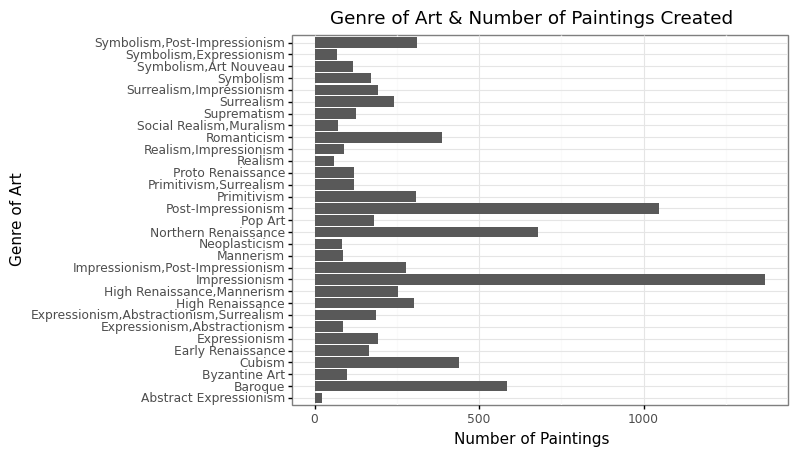

<ggplot: (88543160052)>

In [23]:
ggplot(artists_data) + aes(x = "genre", y = "paintings") + geom_col() +theme_minimal() + theme_bw() + labs(x = "Genre of Art", y = "Number of Paintings") + ggtitle("Genre of Art & Number of Paintings Created") + coord_flip()

In [24]:
images = "best-artworks-of-all-time\images"
artists = list(os.listdir('best-artworks-of-all-time\images'))

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, horizontal_flip=True, vertical_flip=True, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(directory=images, class_mode="categorical", target_size=(224,224), batch_size=16, subset="training", shuffle=True, classes=artists)
valid_generator = train_datagen.flow_from_directory(directory=images, class_mode="categorical", target_size=(224,224), batch_size=16, subset="validation", shuffle=True, classes=artists)

Found 7042 images belonging to 51 classes.
Found 1732 images belonging to 51 classes.


In [26]:
batch_size = 16
train_input_shape = (224, 224, 3)

In [27]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists
                                                   )
valid_generator = train_datagen.flow_from_directory(directory=images,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 7042 images belonging to 51 classes.
Found 1732 images belonging to 51 classes.
Total number of batches = 440 and 108


In [28]:
model = kb.Sequential([
    kb.layers.InputLayer(input_shape =(224, 224, 3)),
    kb.layers.RandomFlip(),
    kb.layers.RandomZoom(0.2),
    kb.layers.RandomRotation(0.1),
    kb.layers.Conv2D(32, (3, 3), activation='relu', padding = "same"),
    kb.layers.Conv2D(64, (3, 3), activation='relu', padding = "same"),
    kb.layers.MaxPooling2D((2, 2)),
    kb.layers.Flatten(),
    kb.layers.Dense(100, activation='relu'),
    kb.layers.Dense(51, activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                      

In [29]:
#compiling model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy', tf.keras.metrics.Precision()])


In [30]:
epochs = 1
history = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
)
model.summary() 

441/441 [==============================] - 751s 2s/step - loss: 3.5965 - categorical_accuracy: 0.1498 - precision: 0.0381 - val_loss: 3.2028 - val_categorical_accuracy: 0.1773 - val_precision: 0.0434
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)     